# Прогноз возможного удоя коровы и расчет вероятности получения вкусного молока от коровы.

**Заголовок**: Прогноз возможного удоя коровы и расчет вероятности получения вкусного молока от коровы.

**Описание проекта**: Мы работаем в IT-компании, которая выполняет на заказ проекты по машинному обучению. 

К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. 

**Цель исследования**: 

Нужно создать две прогнозные модели для отбора бурёнок в поголовье:
- Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

**Ход исследования**:

- Подготовка данных: загрузка и изучение данных, заполнение пропусков, обработка дубликатов
- Исследовательский анализ данных: изучение основных параметров объектов, их распределения, зависимости.
- Корреляционный анализ признаков в датасете ferma_main.csv
- Обучение трех моделей линейной регрессии
- Спрогнозировать вкус молока коров, которых фермер хочет купить
- Итоговый вывод 

## 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,      
    mean_absolute_error,
    precision_score,
    r2_score,
    recall_score
)
from scipy import stats as st

In [2]:
ferma_main = pd.read_csv("/datasets/ferma_main.csv", sep=';')
display(ferma_main.head())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [3]:
# Приведем названия столбцов к snake_case
ferma_main = ferma_main.rename(columns={'Удой, кг': 'milk_yield', 
                                'ЭКЕ (Энергетическая кормовая единица)': 'energy_feed_unit',
       'Сырой протеин, г': 'raw_protein', 
                                'СПО (Сахаро-протеиновое соотношение)':'sugar_protein_relationship', 
                                'Порода':'breed',
       'Тип пастбища': 'pasture_type', 
                                'порода папы_быка': 'bull_breed', 
                                'Жирность,%': 'fat_content', 
                                'Белок,%': 'protein',
       'Вкус молока': 'taste_of_milk', 
                                'Возраст': 'age'})
display(ferma_main.head())

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_relationship,breed,pasture_type,bull_breed,fat_content,protein,taste_of_milk,age
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


- id — уникальный идентификатор коровы.
- milk_yield — масса молока, которую корова даёт в год (в килограммах).
- energy_feed_unit — показатель питательности корма коровы.
- raw_protein — содержание сырого протеина в корме (в граммах).
- sugar_protein_relationship — отношение сахара к протеину в корме коровы.
- breed — порода коровы.
- pasture_type — ландшафт лугов, на которых паслась корова.
- bull_breed — порода папы коровы.
- fat_content — содержание жиров в молоке (в процентах).
- protein — содержание белков в молоке (в процентах).
- taste_of_milk — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
- age — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

In [4]:
ferma_dad = pd.read_csv("/datasets/ferma_dad.csv", sep=';')
display(ferma_dad.head())

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [5]:
# Приведем названия столбцов к snake_case
ferma_dad = ferma_dad.rename(columns={'Имя Папы': 'name_of_dad'})
display(ferma_dad.head())

,id,name_of_dad
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


- id — уникальный идентификатор коровы.
- name_of_dad — имя папы коровы.

In [6]:
cow_buy = pd.read_csv("/datasets/cow_buy.csv", sep=';')
display(cow_buy.head())
print(cow_buy.columns)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


Index(['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя_папы',
       'Текущая_жирность,%', 'Текущий_уровень_белок,%', 'Возраст'],
      dtype='object')


In [7]:
# Приведем названия столбцов к snake_case
cow_buy = cow_buy.rename(columns={'Порода': 'breed', 'Тип пастбища': 'pasture_type', 
                                  'порода папы_быка': 'bull_breed', 
                                  'Имя_папы': 'name_of_dad',
       'Текущая_жирность,%': 'fat_content', 
                                  'Текущий_уровень_белок,%': 'protein', 
                                  'Возраст': 'age'})
display(cow_buy.head())

,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


- breed — порода коровы.
- pasture_type — ландшафт лугов, на которых паслась корова.
- bull_breed — порода папы коровы.
- name_of_dad — имя папы коровы.
- fat_content — содержание жиров в молоке (в процентах).
- protein — содержание белков в молоке (в процентах).
- age — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

In [8]:
ferma_main.info()
ferma_main.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          634 non-null    int64 
 1   milk_yield                  634 non-null    int64 
 2   energy_feed_unit            634 non-null    object
 3   raw_protein                 634 non-null    int64 
 4   sugar_protein_relationship  634 non-null    object
 5   breed                       634 non-null    object
 6   pasture_type                634 non-null    object
 7   bull_breed                  634 non-null    object
 8   fat_content                 634 non-null    object
 9   protein                     634 non-null    object
 10  taste_of_milk               634 non-null    object
 11  age                         634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


,id,milk_yield,raw_protein
count,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,1922.682965
std,183.096982,1638.401021,182.392548
min,1.000000,5204.000000,1660.000000
25%,159.250000,5751.750000,1772.250000
50%,317.500000,6130.500000,1880.500000
75%,475.750000,6501.000000,2058.750000
max,629.000000,45616.000000,2349.000000


In [9]:
ferma_dad.info()
ferma_dad.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           629 non-null    int64 
 1   name_of_dad  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


In [10]:
cow_buy.info()
cow_buy.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   breed         20 non-null     object
 1   pasture_type  20 non-null     object
 2   bull_breed    20 non-null     object
 3   name_of_dad   20 non-null     object
 4   fat_content   20 non-null     object
 5   protein       20 non-null     object
 6   age           20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age
count,20,20,20,20,20,20,20
unique,2,2,2,4,12,12,2
top,РефлешнСоверинг,равнинное,Соверин,Буйный,"3,4","3,074",более_2_лет
freq,11,11,12,8,3,5,15


**Вывод**:
 - Загрузили и изучили данные
 - названия столбцов привели к snake_case

##  2. Предобработка данных

In [11]:
# Проверим пропуски в ferma_main
ferma_main.isna().sum()

id                            0
milk_yield                    0
energy_feed_unit              0
raw_protein                   0
sugar_protein_relationship    0
breed                         0
pasture_type                  0
bull_breed                    0
fat_content                   0
protein                       0
taste_of_milk                 0
age                           0
dtype: int64

In [12]:
# Проверим пропуски в ferma_dad
ferma_dad.isna().sum()

id             0
name_of_dad    0
dtype: int64

In [13]:
# Проверим пропуски в cow_buy
cow_buy.isna().sum()

breed           0
pasture_type    0
bull_breed      0
name_of_dad     0
fat_content     0
protein         0
age             0
dtype: int64

Пропусков в датасетах нет.

In [14]:
# Проверим явные дубликаты в ferma_main
ferma_main.duplicated().sum()
ferma_main[ferma_main.duplicated()]

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_relationship,breed,pasture_type,bull_breed,fat_content,protein,taste_of_milk,age
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
632,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
633,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет


In [15]:
ferma_main = ferma_main.drop_duplicates()

In [16]:
display(ferma_main.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          629 non-null    int64 
 1   milk_yield                  629 non-null    int64 
 2   energy_feed_unit            629 non-null    object
 3   raw_protein                 629 non-null    int64 
 4   sugar_protein_relationship  629 non-null    object
 5   breed                       629 non-null    object
 6   pasture_type                629 non-null    object
 7   bull_breed                  629 non-null    object
 8   fat_content                 629 non-null    object
 9   protein                     629 non-null    object
 10  taste_of_milk               629 non-null    object
 11  age                         629 non-null    object
dtypes: int64(3), object(9)
memory usage: 63.9+ KB


None

In [17]:
# Проверим явные дубликаты в ferma_dad
ferma_dad.duplicated().sum()

0

In [18]:
# Проверим явные дубликаты в cow_buy
cow_buy.duplicated().sum()

4

In [19]:
cow_buy[cow_buy.duplicated()]

,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


In [20]:
cow_buy = cow_buy.drop_duplicates()
cow_buy.duplicated().sum()

0

In [21]:
# Проверим неявные дубликаты ferma_main
ferma_main['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [22]:
ferma_main['pasture_type'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

In [23]:
ferma_main = ferma_main.replace({'pasture_type': {'Равнинные': 'Равнинное'}})

In [24]:
ferma_main['pasture_type'].unique()

array(['Равнинное', 'Холмистое'], dtype=object)

In [25]:
ferma_main['bull_breed'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [26]:
ferma_main = ferma_main.replace({'bull_breed': {'Айдиалл': 'Айдиал'}})

In [27]:
ferma_main['bull_breed'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [28]:
ferma_main['taste_of_milk'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [29]:
ferma_main['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

In [30]:
# Проверим неявные дубликаты ferma_dad
ferma_dad['name_of_dad'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [31]:
# Проверим неявные дубликаты cow_buy
cow_buy['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [32]:
cow_buy['pasture_type'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [33]:
cow_buy['bull_breed'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [34]:
cow_buy['name_of_dad'].unique()

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

In [35]:
cow_buy['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

In [36]:
# Проверим, корректные ли типы данных у датафрейма ferma_main
display(ferma_main.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          629 non-null    int64 
 1   milk_yield                  629 non-null    int64 
 2   energy_feed_unit            629 non-null    object
 3   raw_protein                 629 non-null    int64 
 4   sugar_protein_relationship  629 non-null    object
 5   breed                       629 non-null    object
 6   pasture_type                629 non-null    object
 7   bull_breed                  629 non-null    object
 8   fat_content                 629 non-null    object
 9   protein                     629 non-null    object
 10  taste_of_milk               629 non-null    object
 11  age                         629 non-null    object
dtypes: int64(3), object(9)
memory usage: 63.9+ KB


None

In [37]:
ferma_main['energy_feed_unit'] = ferma_main['energy_feed_unit'].apply(lambda x: x.replace(',','.'))
ferma_main['sugar_protein_relationship'] = ferma_main['sugar_protein_relationship'].apply(lambda x: x.replace(',','.'))
ferma_main['fat_content'] = ferma_main['fat_content'].apply(lambda x: x.replace(',','.'))
ferma_main['protein'] = ferma_main['protein'].apply(lambda x: x.replace(',','.'))
ferma_main['energy_feed_unit'] = pd.to_numeric(ferma_main['energy_feed_unit']).astype('float')
ferma_main['sugar_protein_relationship'] = pd.to_numeric(ferma_main['sugar_protein_relationship']).astype('float')
ferma_main['fat_content'] = pd.to_numeric(ferma_main['fat_content']).astype('float')
ferma_main['protein'] = pd.to_numeric(ferma_main['protein']).astype('float')
display(ferma_main.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          629 non-null    int64  
 1   milk_yield                  629 non-null    int64  
 2   energy_feed_unit            629 non-null    float64
 3   raw_protein                 629 non-null    int64  
 4   sugar_protein_relationship  629 non-null    float64
 5   breed                       629 non-null    object 
 6   pasture_type                629 non-null    object 
 7   bull_breed                  629 non-null    object 
 8   fat_content                 629 non-null    float64
 9   protein                     629 non-null    float64
 10  taste_of_milk               629 non-null    object 
 11  age                         629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.9+ KB


None

In [38]:
# Проверим, корректные ли типы данных у датафрейма ferma_dad
display(ferma_dad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           629 non-null    int64 
 1   name_of_dad  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

In [39]:
# Проверим, корректные ли типы данных у датафрейма cow_buy
display(cow_buy.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   breed         16 non-null     object
 1   pasture_type  16 non-null     object
 2   bull_breed    16 non-null     object
 3   name_of_dad   16 non-null     object
 4   fat_content   16 non-null     object
 5   protein       16 non-null     object
 6   age           16 non-null     object
dtypes: object(7)
memory usage: 1.0+ KB


None

In [40]:
cow_buy['fat_content'] = cow_buy['fat_content'].apply(lambda x: x.replace(',','.'))
cow_buy['protein'] = cow_buy['protein'].apply(lambda x: x.replace(',','.'))
cow_buy['fat_content'] = pd.to_numeric(cow_buy['fat_content']).astype('float')
cow_buy['protein'] = pd.to_numeric(cow_buy['protein']).astype('float')
display(cow_buy.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         16 non-null     object 
 1   pasture_type  16 non-null     object 
 2   bull_breed    16 non-null     object 
 3   name_of_dad   16 non-null     object 
 4   fat_content   16 non-null     float64
 5   protein       16 non-null     float64
 6   age           16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


None

**Вывод**:
 - Проверили данные на дубликаты
 - В датафрейме ferma_main удалены неявные дубликаты в столбцах bull_breed и pasture_type
 - В датафреймах ferma_dad и cow_buy неявные дубликаты не обнаружены
 - Исправлены типы данных в столбцах energy_feed_unit, sugar_protein_relationship, fat_content, protein в датафрейме ferma_main
 - Исправлены типы данных в столбцах fat_content, protein в датафрейме cow_buy

## 3. Исследовательский анализ данных

### 3.1. Проведем статистический анализ всех признаков.

In [41]:
ferma_main.describe()

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_relationship,fat_content,protein
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Максимальное значение поля 'milk_yield' 45616, это сильно большое значение по сравнению с остальными, которые меньше 8000. Это выброс, заменим его на среднее значение в столбце.

In [42]:
ferma_main.loc[ferma_main['milk_yield'] > 8000, 'milk_yield'] = ferma_main['milk_yield'].mean()
ferma_main.describe()

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_relationship,fat_content,protein
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6126.067966,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,475.484625,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


In [43]:
ferma_dad.describe()

,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


In [44]:
cow_buy.describe()

,fat_content,protein
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


### 3.2. Построим графики для каждого признака.

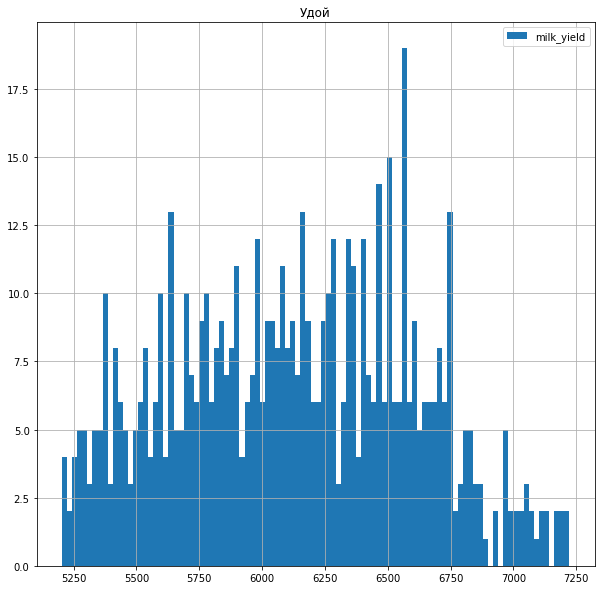

In [45]:
# Построим графики для датафрейма ferma_main
ferma_main['milk_yield'].hist(bins=100, figsize = (10,10), legend=True)
plt.title('Удой')
plt.show()

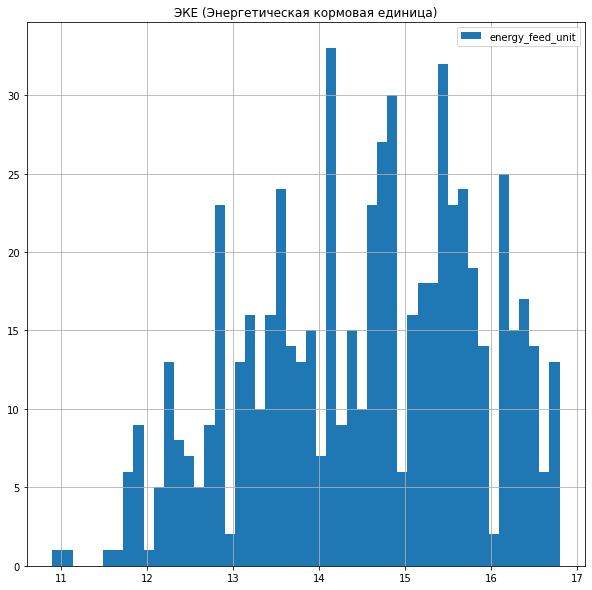

In [46]:
ferma_main['energy_feed_unit'].hist(bins=50, figsize = (10,10), legend=True)
plt.title('ЭКЕ (Энергетическая кормовая единица)')
plt.show()

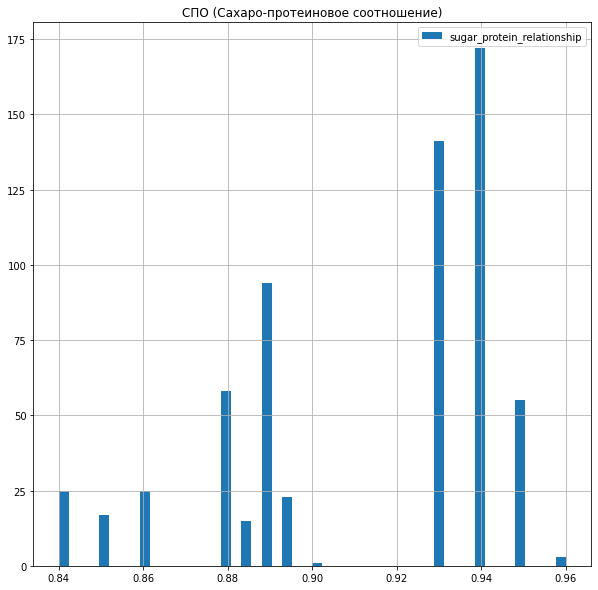

In [47]:
ferma_main['sugar_protein_relationship'].hist(bins=50, figsize = (10,10), legend=True)
plt.title('СПО (Сахаро-протеиновое соотношение)')
plt.show()

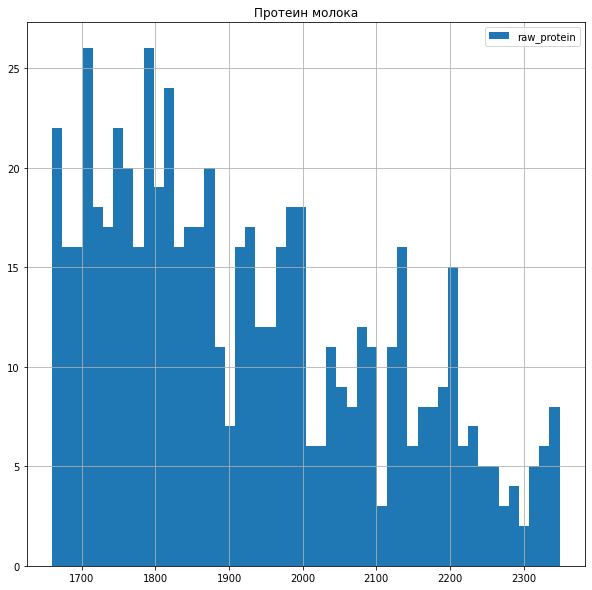

In [48]:
ferma_main['raw_protein'].hist(bins=50, figsize = (10,10), legend=True)
plt.title('Протеин молока')
plt.show()

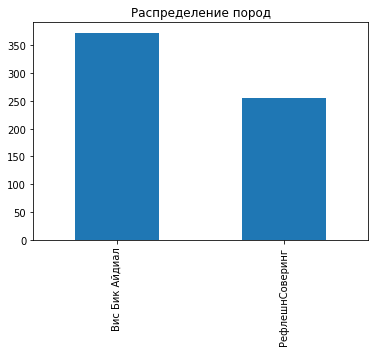

In [49]:
ferma_main['breed'].value_counts().plot(kind='bar')
plt.title('Распределение пород')
plt.show()

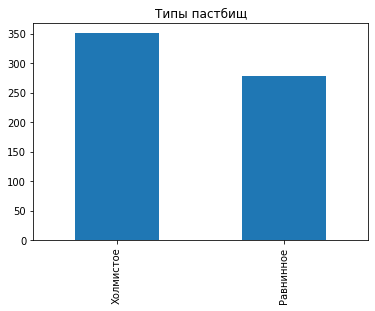

In [50]:
ferma_main['pasture_type'].value_counts().plot(kind='bar')
plt.title('Типы пастбищ')
plt.show()

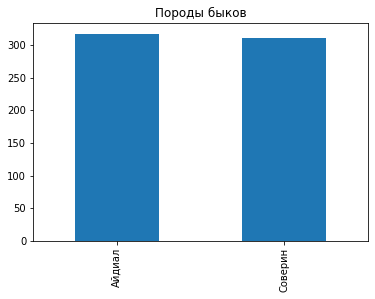

In [51]:
ferma_main['bull_breed'].value_counts().plot(kind='bar')
plt.title('Породы быков')
plt.show()

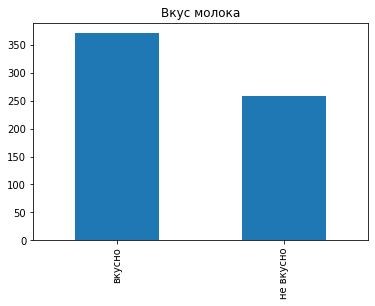

In [52]:
ferma_main['taste_of_milk'].value_counts().plot(kind='bar')
plt.title('Вкус молока')
plt.show()

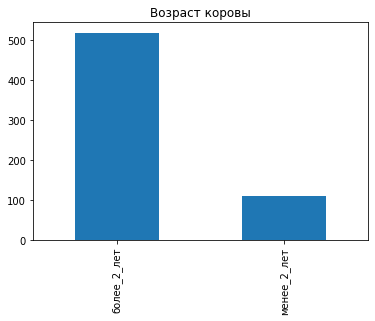

In [53]:
ferma_main['age'].value_counts().plot(kind='bar')
plt.title('Возраст коровы')
plt.show()

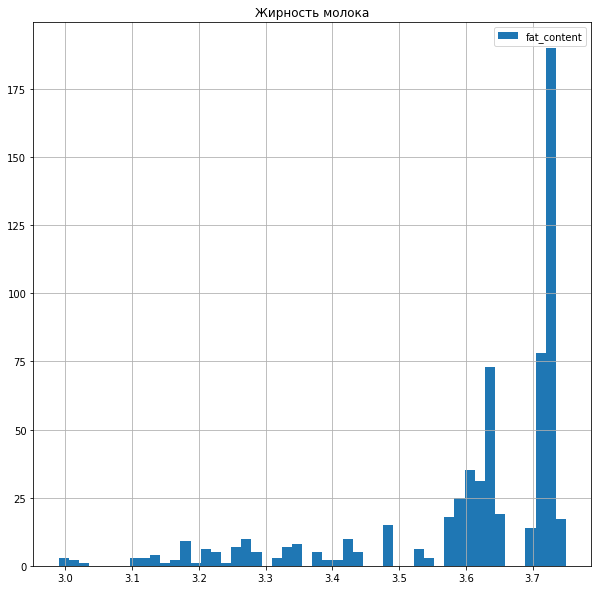

In [54]:
ferma_main['fat_content'].hist(bins=50, figsize = (10,10), legend=True)
plt.title('Жирность молока')
plt.show()

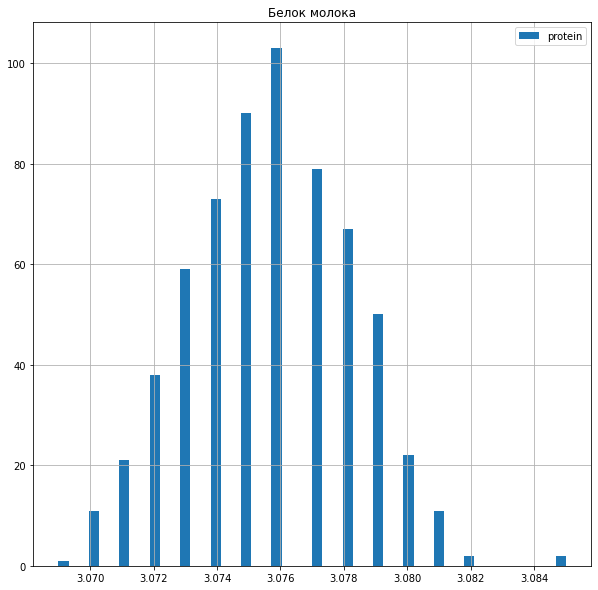

In [55]:
ferma_main['protein'].hist(bins=50, figsize = (10,10), legend=True)
plt.title('Белок молока')
plt.show()

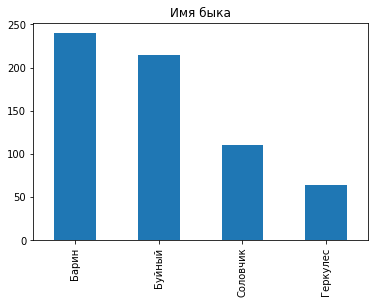

In [56]:
# Построим графики для датафрейма ferma_dad
ferma_dad['name_of_dad'].value_counts().plot(kind='bar')
plt.title('Имя быка')
plt.show()

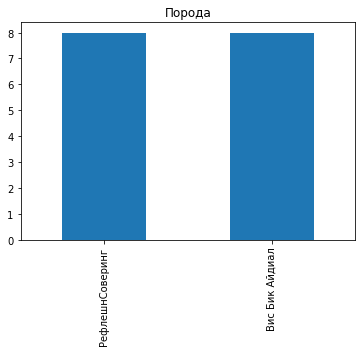

In [57]:
# Построим графики для датафрейма cow_buy
cow_buy['breed'].value_counts().plot(kind='bar')
plt.title('Порода')
plt.show()

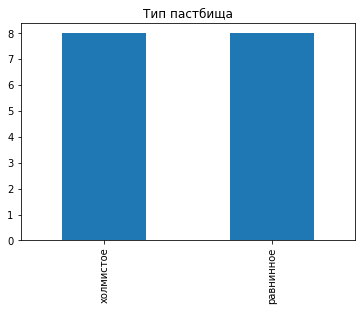

In [58]:
cow_buy['pasture_type'].value_counts().plot(kind='bar')
plt.title('Тип пастбища')
plt.show()

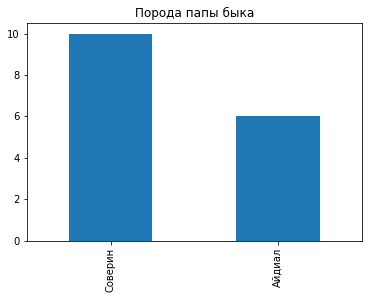

In [59]:
cow_buy['bull_breed'].value_counts().plot(kind='bar')
plt.title('Порода папы быка')
plt.show()

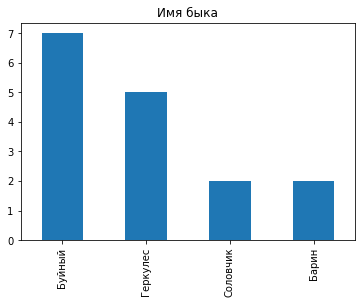

In [60]:
cow_buy['name_of_dad'].value_counts().plot(kind='bar')
plt.title('Имя быка')
plt.show()

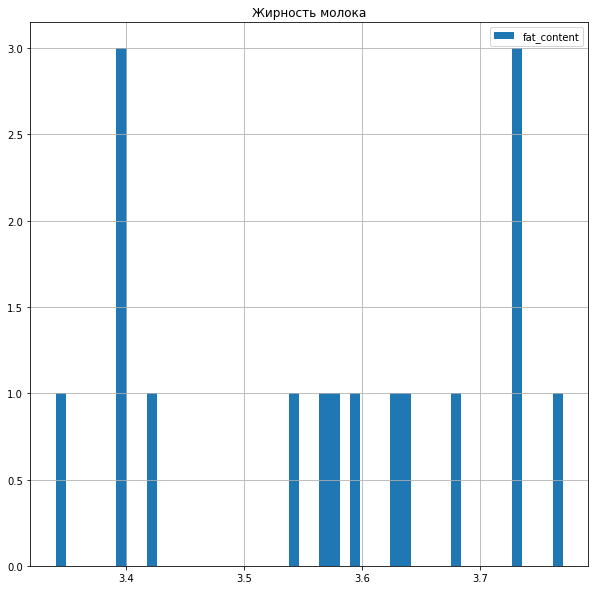

In [61]:
cow_buy['fat_content'].hist(bins=50, figsize = (10,10), legend=True)
plt.title('Жирность молока')
plt.show()

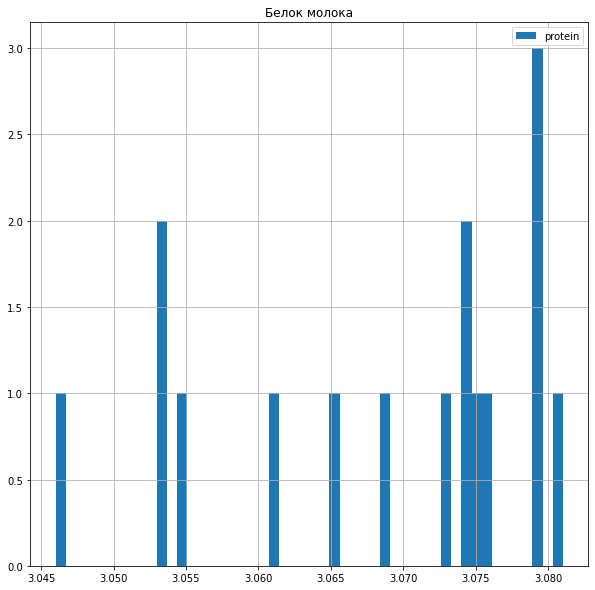

In [62]:
cow_buy['protein'].hist(bins=50, figsize = (10,10), legend=True)
plt.title('Белок молока')
plt.show()

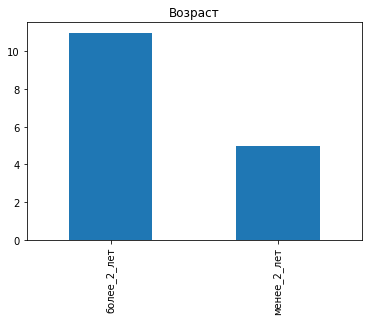

In [63]:
cow_buy['age'].value_counts().plot(kind='bar')
plt.title('Возраст')
plt.show()

### 3.3. Сделаем выводы о данных.

**Датафрейм ferma_main:**
- Максимальное значение поля "milk_yield" = 7222 кг, число коров, удой которых от 7000 до 7222 кг, меньше всего. 
- Максимальное значение поля "energy_feed_unit" 16,8. На гистограмме небольшой "островок" на значении 11. Но его удалять не нужно для корректного анализа данных.
- Максимальное значение поля "sugar_protein_relationship" = 0.96. На гистограмме данный параметр распределен на интервалах (0.84; 0.86), (0,88; 0.9), (0.93; 0.96). Значений данного параметра 0.9 и 0.96 меньше всего.
- Максимальное значение поля "raw_protein" = 2349. Больше всего значений данного параметра от 1660 до 1900 г. 
- 2 породы коров : Вис Бик Айдиал и РефлешнСоверинг. Больше всего коров с первой породой.
- 2 типа пастбищ : Холмистое и Равнинное. Больше всего коров, пасущихся на первом пастбище.
- 2 породы папы быка : Айдиал и Соверин. Число быков обеих пород примерно одинаково.
- 2 категории вкуса молока : вкусно и не вкусно. Больше всего коров, дающих вкусное молоко.
- 2 категории возраста коровы : больше и меньше 2 лет. Больше всего коров, возраст которых больше 2 лет.
- Максимальная Жирность молока =  3.75. Но больше всего коров, дающих молоко, жирность которого примерно 3.72. Очень маленькое число коров, дающих молоко, жирность которого 3-3.55.  
- Максимальный уровень белка молока 3.085. Больше всего коров, дающих молоко, белок которого 3.075-3.076. 

Не все количественные данные на гистограммах распределены нормально. Можно заметить, что у белка на гистограмме имеется нормальное распределение.

**Датафрейм ferma_dad:**
- 4 имени быков : Барин, Буйный, Соловчик, Геркулес. Больше всего коров, имя отца которой Барин. Меньше всего - Геркулес.

**Датафрейм cow_buy:**
- 2 породы коров : Вис Бик Айдиал и РефлешнСоверинг. Больше всего коров с первой породой.
- 2 типа пастбищ : Холмистое и Равнинное. Больше всего коров, пасущихся на первом пастбище.
- 2 породы папы быка : Айдиал и Соверин. Число быков породы Соверин больше.
- 4 имени быков : Барин, Буйный, Соловчик, Геркулес. Больше всего коров, имя отца которой Буйный. Меньше всего - Барин.
- Максимальная Жирность молока =  3.77. Но больше всего коров, дающих молоко, жирность которого примерно 3.4 и 3.75. 
- Максимальный уровень белка молока 3.081. Больше всего коров, дающих молоко, белок которого 3.079. 
- 2 категории возраста коровы : больше и меньше 2 лет. Больше всего коров, возраст которых больше 2 лет.

## 4. Корреляционный анализ

### 4.1. Рассчитаем коэффициенты корреляции между всеми признаками.

<AxesSubplot:>

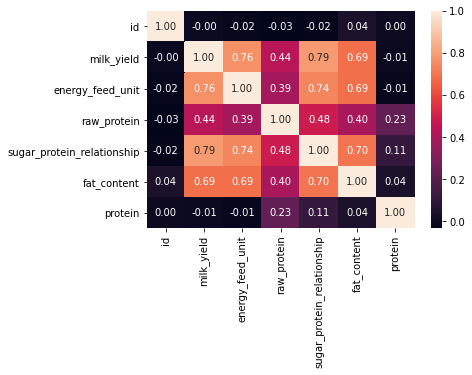

In [64]:
sns.heatmap(ferma_main.corr(method='spearman'), annot=True, fmt='.2f') 

### 4.2. Построим диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков.

#### Диаграммы рассеяния для признака Удой и количественных признаков энергетическая_кормовая_единица, сырой_протеин, сахаро_протеиновое_соотношение, жирность, белок с учетом породы коровы.

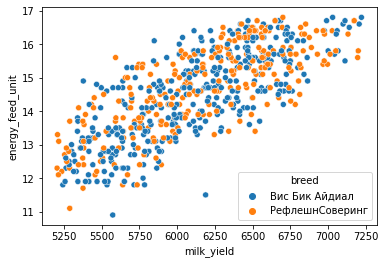

In [65]:
sns.scatterplot(
    x='milk_yield',
    y='energy_feed_unit', 
    data=ferma_main,
    hue='breed'); 

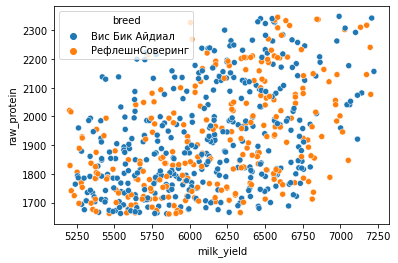

In [66]:
sns.scatterplot(
    x='milk_yield',
    y='raw_protein', 
    data=ferma_main,
    hue='breed'); 

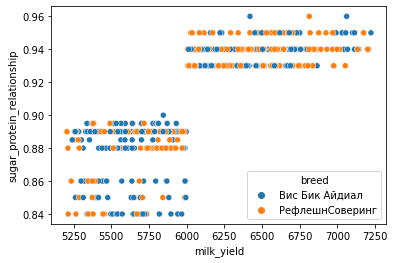

In [67]:
sns.scatterplot(
    x='milk_yield',
    y='sugar_protein_relationship', 
    data=ferma_main,
    hue='breed'); 

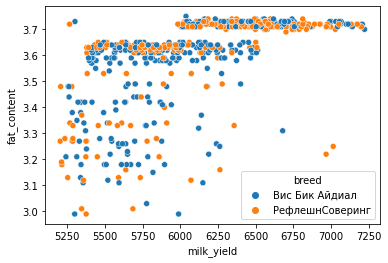

In [68]:
sns.scatterplot(
    x='milk_yield',
    y='fat_content', 
    data=ferma_main,
    hue='breed'); 

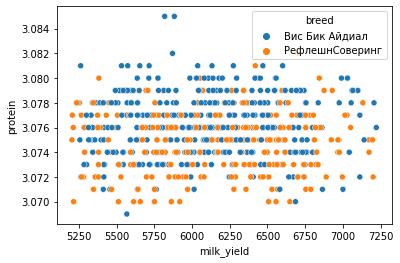

In [69]:
sns.scatterplot(
    x='milk_yield',
    y='protein', 
    data=ferma_main,
    hue='breed'); 

#### Диаграммы рассеяния для признака Удой и количественных признаков энергетическая_кормовая_единица, сырой_протеин, сахаро_протеиновое_соотношение, жирность, белок с учетом типа пастбища.

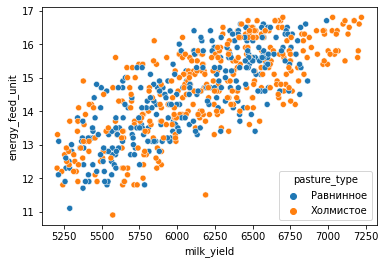

In [70]:
sns.scatterplot(
    x='milk_yield',
    y='energy_feed_unit', 
    data=ferma_main,
    hue='pasture_type'); 

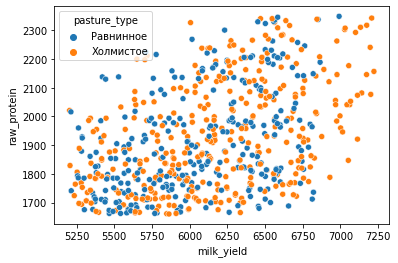

In [71]:
sns.scatterplot(
    x='milk_yield',
    y='raw_protein', 
    data=ferma_main,
    hue='pasture_type'); 

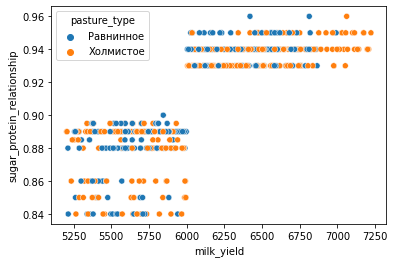

In [72]:
sns.scatterplot(
    x='milk_yield',
    y='sugar_protein_relationship', 
    data=ferma_main,
    hue='pasture_type'); 

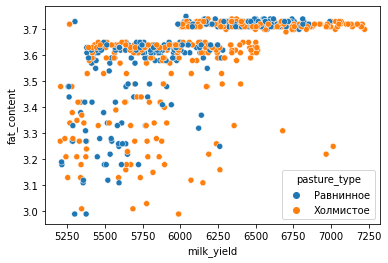

In [73]:
sns.scatterplot(
    x='milk_yield',
    y='fat_content', 
    data=ferma_main,
    hue='pasture_type'); 

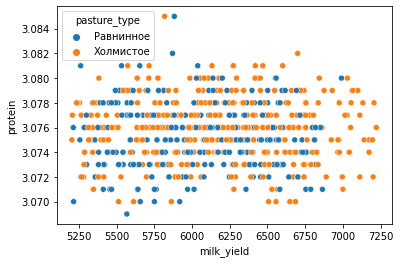

In [74]:
sns.scatterplot(
    x='milk_yield',
    y='protein', 
    data=ferma_main,
    hue='pasture_type'); 

#### Диаграммы рассеяния для признака Удой и количественных признаков энергетическая_кормовая_единица, сырой_протеин, сахаро_протеиновое_соотношение, жирность, белок с учетом породы папы быка.

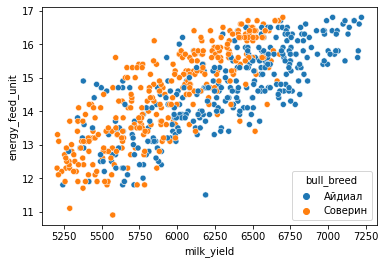

In [75]:
sns.scatterplot(
    x='milk_yield',
    y='energy_feed_unit', 
    data=ferma_main,
    hue='bull_breed'); 

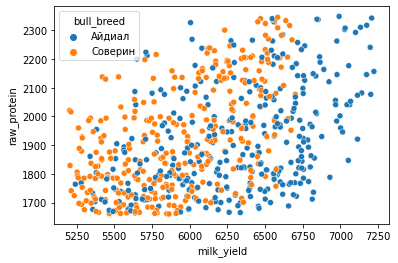

In [76]:
sns.scatterplot(
    x='milk_yield',
    y='raw_protein', 
    data=ferma_main,
    hue='bull_breed'); 

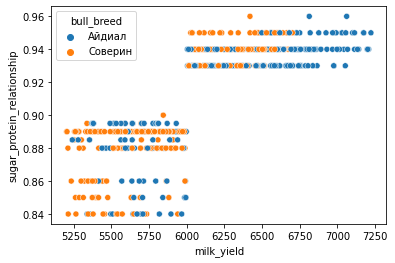

In [77]:
sns.scatterplot(
    x='milk_yield',
    y='sugar_protein_relationship', 
    data=ferma_main,
    hue='bull_breed'); 

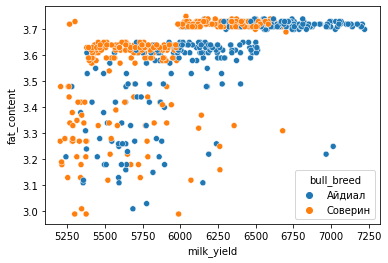

In [78]:
sns.scatterplot(
    x='milk_yield',
    y='fat_content', 
    data=ferma_main,
    hue='bull_breed'); 

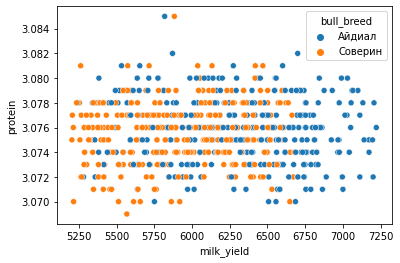

In [79]:
sns.scatterplot(
    x='milk_yield',
    y='protein', 
    data=ferma_main,
    hue='bull_breed'); 

#### Диаграммы рассеяния для признака Удой и количественных признаков энергетическая_кормовая_единица, сырой_протеин, сахаро_протеиновое_соотношение, жирность, белок с учетом вкуса молока.

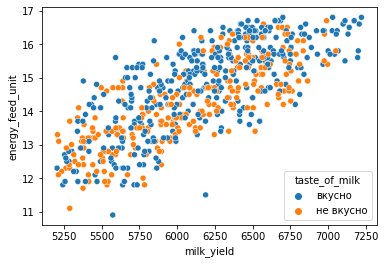

In [80]:
sns.scatterplot(
    x='milk_yield',
    y='energy_feed_unit', 
    data=ferma_main,
    hue='taste_of_milk'); 

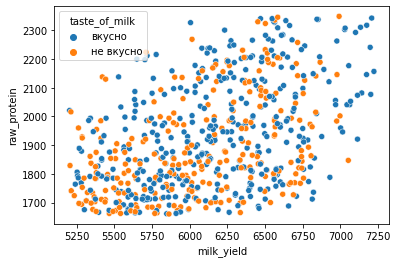

In [81]:
sns.scatterplot(
    x='milk_yield',
    y='raw_protein', 
    data=ferma_main,
    hue='taste_of_milk'); 

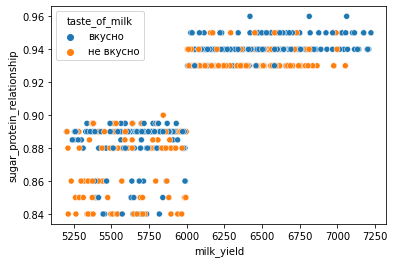

In [82]:
sns.scatterplot(
    x='milk_yield',
    y='sugar_protein_relationship', 
    data=ferma_main,
    hue='taste_of_milk'); 

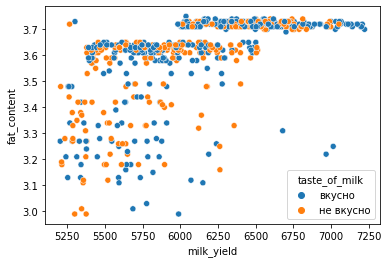

In [83]:
sns.scatterplot(
    x='milk_yield',
    y='fat_content', 
    data=ferma_main,
    hue='taste_of_milk'); 

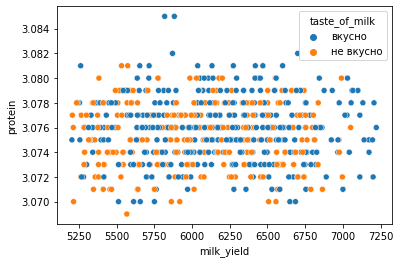

In [84]:
sns.scatterplot(
    x='milk_yield',
    y='protein', 
    data=ferma_main,
    hue='taste_of_milk'); 

#### Диаграммы рассеяния для признака Удой и количественных признаков энергетическая_кормовая_единица, сырой_протеин, сахаро_протеиновое_соотношение, жирность, белок с учетом возраста коровы.

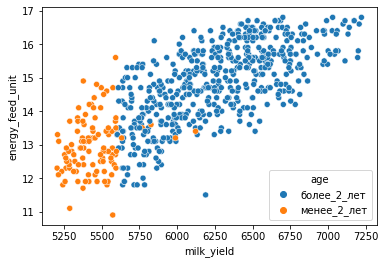

In [85]:
sns.scatterplot(
    x='milk_yield',
    y='energy_feed_unit', 
    data=ferma_main,
    hue='age'); 

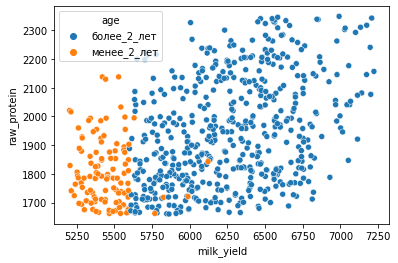

In [86]:
sns.scatterplot(
    x='milk_yield',
    y='raw_protein', 
    data=ferma_main,
    hue='age'); 

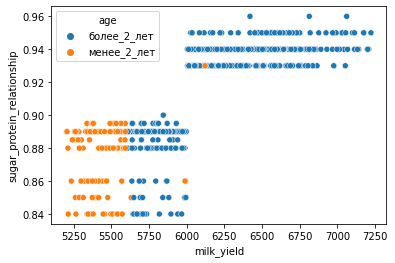

In [87]:
sns.scatterplot(
    x='milk_yield',
    y='sugar_protein_relationship', 
    data=ferma_main,
    hue='age'); 

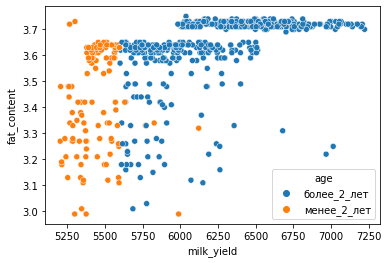

In [88]:
sns.scatterplot(
    x='milk_yield',
    y='fat_content', 
    data=ferma_main,
    hue='age'); 

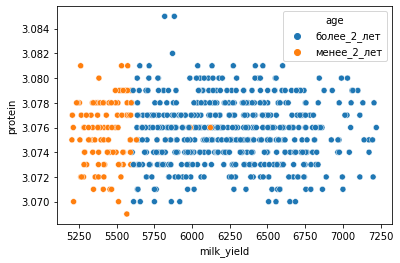

In [89]:
sns.scatterplot(
    x='milk_yield',
    y='protein', 
    data=ferma_main,
    hue='age'); 

### 4.3. Сделаем выводы о взаимосвязи признаков.

#### Какой тип взаимосвязи между целевым и входными признаками? 

Наблюдаются:
 - высокая линейная связь между milk_yield и energy_feed_unit (0.76 по шкале Чеддока). Но также на графике можно заметить несильную квадратичную зависимость.
 - высокая линейная связь между milk_yield и sugar_protein_relationship (0.79 по шкале Чеддока) 
 - заметная линейная связь между milk_yield и fat_content (0.69 по шкале Чеддока) 
 - умеренная связь между milk_yield и raw_protein (0.44 по шкале Чеддока) 

Между milk_yield и protein не наблюдается линейной связи. 

Мультиколлинеарность не наблюдается.

## 5. Обучение модели линейной регрессии

### 5.1. Подготовьте данные датасета ferma_main.csv и обучите на них первую модель LinearRegression.

Целевой признак - milk_yield

Входные признаки - energy_feed_unit, sugar_protein_relationship, raw_protein так как между ними и целевым признаком наблюдается линейная зависимость. 
Также к входным признакам я бы отнесла bull_breed, breed, age, pasture_type.

In [90]:
# Разобьем данные на тренировочную и тестовую выборки.
from sklearn.model_selection import train_test_split
ferma_main_1 = ferma_main
RANDOM_STATE = 42
X = ferma_main_1.drop('milk_yield', axis=1)
y = ferma_main_1['milk_yield']
X_train, X_test, y_train, y_test_1 = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
) 

In [91]:
# Кодируем категориальные признаки с помощью OneHotEncoder.
cat_col_names = ['age', 'breed', 'pasture_type', 'bull_breed']
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names]) 
X_test_ohe = encoder.transform(X_test[cat_col_names]) 
encoder_col_names = encoder.get_feature_names() 
df_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)

In [92]:
# Масштабируем количественные признаки с помощью StandardScaler.
num_col_names = ['energy_feed_unit', 'sugar_protein_relationship', 'raw_protein']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [93]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [94]:
# Обучим модель на подготовленных данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_1 = model_lr.predict(X_test)

In [95]:
# рассчитаем R²
r2 = r2_score(y_test_1, predictions_1)  
print(r2)

0.818864861589124


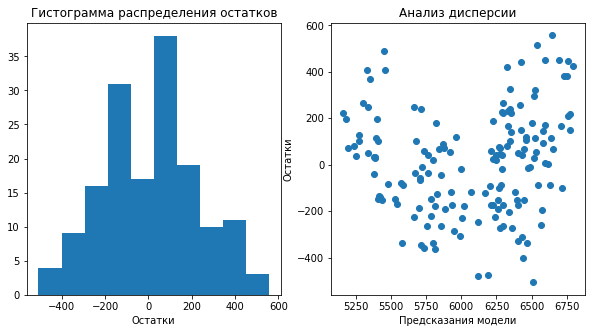

In [96]:
# проведем анализ остатков
# перед этим рассчитаем остатки
residuals = y_test_1 - predictions_1

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_1, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод:**
- По гистограмме распределения остатков наблюдается нормальное распределение со смещением вправо. Это значит, что модель занижает прогнозные значения.
- R² = 0.818864861589124

### 5.2. Подготовьте данные датасета  с учётом связи входных признаков с целевым и обучим на них вторую модель LinearRegression.

In [97]:
ferma_main_2 = ferma_main.copy(deep=False)

In [98]:
# По графикам рассеяния с полем sugar_protein_relationship видно, что это поле можно преобразовать в категориальное бинарное (1 - если больше 
# или равно 0.915, иначе 0)
ferma_main_2['sugar_protein_relationship'] = ferma_main_2['sugar_protein_relationship'].apply(lambda x: 1 if x>= 0.915 else 0)

In [99]:
# Чтобы убрать нелинейность между energy_feed_unit и milk_yield.
ferma_main_2['energy_feed_unit_2'] = ferma_main_2['energy_feed_unit'] ** 2
display(ferma_main_2.head())

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_relationship,breed,pasture_type,bull_breed,fat_content,protein,taste_of_milk,age,energy_feed_unit_2
0,1,5863.0,14.2,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,201.64
1,2,5529.0,12.8,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,163.84
2,3,5810.0,14.0,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,196.00
3,4,5895.0,12.4,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,153.76
4,5,5302.0,12.8,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,163.84


In [100]:
# Разобьем данные на тренировочную и тестовую выборки.
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42
X = ferma_main_2.drop('milk_yield', axis=1)
y = ferma_main_2['milk_yield']
X_train, X_test, y_train, y_test_2 = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
) 

In [101]:
# Масштабируем количественные признаки с помощью StandardScaler.
num_col_names = ['energy_feed_unit_2', 'sugar_protein_relationship', 'raw_protein', 'protein']
scaler_2 = StandardScaler()
X_train_scaled = scaler_2.fit_transform(X_train[num_col_names])
X_test_scaled = scaler_2.transform(X_test[num_col_names])

In [102]:
# Кодируем категориальные признаки с помощью OneHotEncoder.
cat_col_names = ['age', 'breed', 'pasture_type', 'bull_breed']
encoder_2 = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder_2.fit_transform(X_train[cat_col_names]) 
X_test_ohe = encoder_2.transform(X_test[cat_col_names]) 
encoder_col_names = encoder_2.get_feature_names() 
df_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)

In [103]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [104]:
# Обучим модель на подготовленных данных
model_lr_2  = LinearRegression()
model_lr_2.fit(X_train, y_train)
predictions_2 = model_lr_2.predict(X_test)

In [105]:
# рассчитаем R²
r2 = r2_score(y_test_2, predictions_2)  
print(r2)

0.8484008974384583


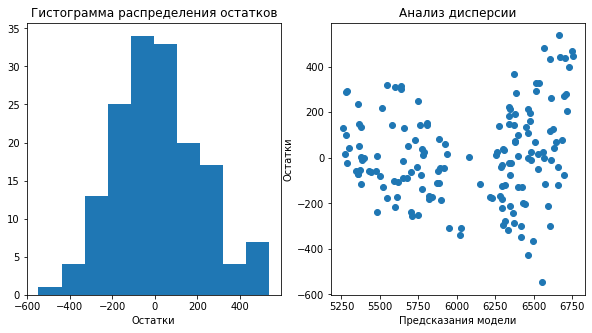

In [106]:
# проведем анализ остатков
# перед этим рассчитаем остатки
residuals = y_test_2 - predictions_2

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_2, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод:**
- По гистограмме распределения остатков наблюдается нормальное распределение с небольним смещением влево. Это значит, что модель завышает прогнозные значения, но уже работает лучше первой модели.
- R² = 0.8484008974384583

### 5.3. Добавим в данные новый признак и обучим на них третью модель LinearRegression.

In [107]:
# Добавим признак Имя Папы из файла ferma_dad.csv, соединив его с остальными данными ferma_main.csv по ключу.
ferma_main_3 = pd.concat([
    ferma_main, ferma_dad['name_of_dad']], ignore_index=False, axis=1)
display(ferma_main_3.head())

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_relationship,breed,pasture_type,bull_breed,fat_content,protein,taste_of_milk,age,name_of_dad
0,1,5863.0,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529.0,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810.0,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895.0,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302.0,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


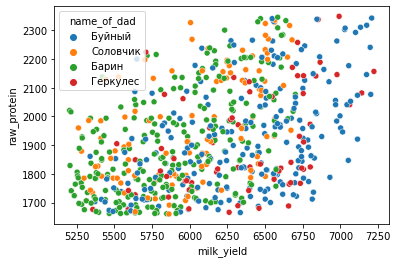

In [108]:
sns.scatterplot(
    x='milk_yield',
    y='raw_protein', 
    data=ferma_main_3,
    hue='name_of_dad'); 

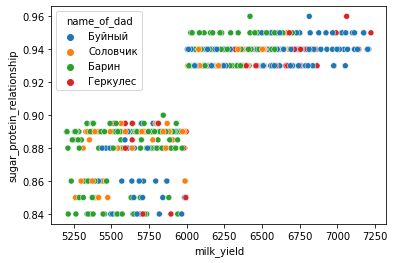

In [109]:
sns.scatterplot(
    x='milk_yield',
    y='sugar_protein_relationship', 
    data=ferma_main_3,
    hue='name_of_dad'); 

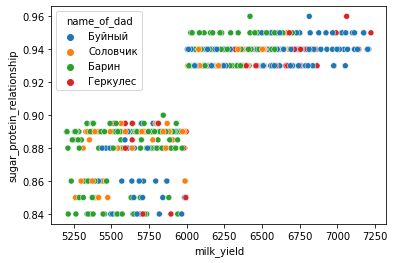

In [110]:
sns.scatterplot(
    x='milk_yield',
    y='sugar_protein_relationship', 
    data=ferma_main_3,
    hue='name_of_dad'); 

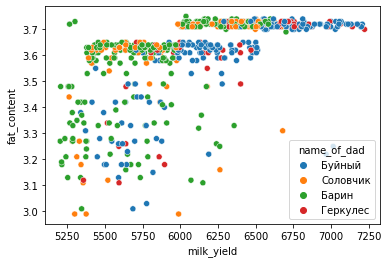

In [111]:
sns.scatterplot(
    x='milk_yield',
    y='fat_content', 
    data=ferma_main_3,
    hue='name_of_dad'); 

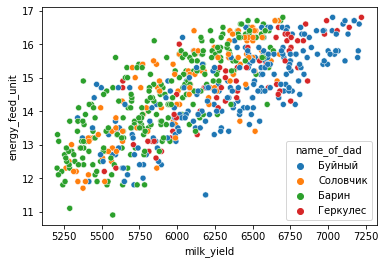

In [112]:
sns.scatterplot(
    x='milk_yield',
    y='energy_feed_unit', 
    data=ferma_main_3,
    hue='name_of_dad'); 

In [113]:
# Разобьем данные на тренировочную и тестовую выборки.
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42
X = ferma_main_3.drop('milk_yield', axis=1)
y = ferma_main_3['milk_yield']
X_train, X_test, y_train, y_test_3 = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
) 

In [114]:
# Масштабируем количественные признаки с помощью StandardScaler.
num_col_names = ['energy_feed_unit', 'sugar_protein_relationship', 'fat_content', 'raw_protein', 'protein']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [115]:
# Кодируем категориальные признаки с помощью OneHotEncoder.
cat_col_names = ['age', 'breed', 'name_of_dad']
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names]) 
X_test_ohe = encoder.transform(X_test[cat_col_names]) 
encoder_col_names = encoder.get_feature_names() 
df_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)

In [116]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [117]:
# Обучим модель на подготовленных данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_3 = model_lr.predict(X_test)

In [118]:
# рассчитаем R²
r2 = r2_score(y_test_3, predictions_3)  
print(r2)

0.8470325654865429


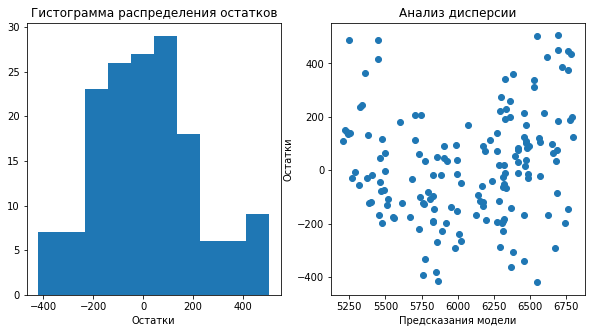

In [119]:
# проведем анализ остатков
# перед этим рассчитаем остатки
residuals = y_test_3 - predictions_3

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_3, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод:**
- По гистограмме распределения остатков наблюдается нормальное распределение с небольним смещением влево. 
- R² = 0.8470325654865429

### 5.4. Сравним качество трёх моделей линейной регрессии.

#### Первая модель:
Нормальное распределение со смещением вправо. 
R² = 0.818864861589124

#### Вторая модель:
Нормальное распределение с небольшим смещением влево.
R² = 0.8484008974384583

#### Третья модель:
Нормальное распределение с небольшим смещением влево.
R² = 0.8470325654865429

### 5.5. Оценим качество каждой моделей по трём метрикам: MSE, MAE, RMSE.

In [120]:
# Метрики для первой модели

In [121]:
mean_squared_error(y_test_1, predictions_1)

49633.89323228784

In [122]:
(mean_squared_error(y_test_1, predictions_1))**0.5

222.78665407130617

In [123]:
mean_absolute_error(y_test_1, predictions_1) 

181.0687479928903

In [124]:
# Метрики для второй модели

In [125]:
mean_squared_error(y_test_2, predictions_2)

41540.55219027797

In [126]:
(mean_squared_error(y_test_2, predictions_2))**0.5

203.81499500840945

In [127]:
mean_absolute_error(y_test_2, predictions_2) 

160.15922159564224

In [128]:
# Метрики для третьей модели

In [129]:
mean_squared_error(y_test_3, predictions_3)

41915.49679022431

In [130]:
(mean_squared_error(y_test_3, predictions_3))**0.5

204.73274479238611

In [131]:
mean_absolute_error(y_test_3, predictions_3) 

163.57833058838344

Среди посчитанных метрик, наилучшие у второй модели.

In [132]:
# Доверительные интервалы
print('95% доверительный интервал =', st.norm.interval(alpha=0.95, loc=np.mean(predictions_3), scale=st.sem(predictions_3)))

95% доверительный интервал = (6002.042510828262, 6143.8736540082555)


/tmp/ipykernel_185/176620490.py:2: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  print('95% доверительный интервал =', st.norm.interval(alpha=0.95, loc=np.mean(predictions_3), scale=st.sem(predictions_3)))


### 5.6. Прогноз удоя коров, которых фермер хочет купить.

In [133]:
# Добавим признаки energy_feed_unit, sugar_protein_relationship, raw_protein
cow_buy_2 = pd.concat([
    cow_buy, ferma_main['energy_feed_unit']], ignore_index=False, axis=1)
cow_buy_2['energy_feed_unit'] = cow_buy_2['energy_feed_unit'] * 1.05
cow_buy_3 = pd.concat([
    cow_buy_2, ferma_main['sugar_protein_relationship']], ignore_index=False, axis=1)
cow_buy_3['sugar_protein_relationship'] = cow_buy_3['sugar_protein_relationship'] * 1.05
cow_buy_4 = pd.concat([
    cow_buy_3, ferma_main['raw_protein']], ignore_index=False, axis=1)
cow_buy_4['raw_protein'] = cow_buy_4['raw_protein'] * 1.05
cow_buy_4 = cow_buy_4.dropna()
display(cow_buy_4.head())

,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age,energy_feed_unit,sugar_protein_relationship,raw_protein
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,14.91,0.93450,1830.15
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,13.44,0.93450,2244.90
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,14.70,0.92925,1946.70
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,13.02,0.92925,2112.60
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,13.44,0.92925,1758.75


In [134]:
display(cow_buy_4)

,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age,energy_feed_unit,sugar_protein_relationship,raw_protein
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,14.910,0.93450,1830.15
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,13.440,0.93450,2244.90
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,14.700,0.92925,1946.70
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,13.020,0.92925,2112.60
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,13.440,0.92925,1758.75
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,13.335,0.92925,1896.30
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.435,0.97650,1896.30
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,14.070,0.93975,1880.55
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,14.385,0.93975,1761.90
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,17.325,0.97650,2444.40


In [135]:
# Подготовим данные
cow_buy_5 = cow_buy_4.copy(deep=False)
cow_buy_5['fat_content'] = cow_buy_5['fat_content'].apply(lambda x: 1 if x>= 3.68 else 0)
cow_buy_5['sugar_protein_relationship'] = cow_buy_5['sugar_protein_relationship'].apply(lambda x: 1 if x>= 0.915 else 0)
cow_buy_5['energy_feed_unit_2'] = cow_buy_5['energy_feed_unit'] ** 2
display(cow_buy_5.head())

,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age,energy_feed_unit,sugar_protein_relationship,raw_protein,energy_feed_unit_2
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0,3.076,более_2_лет,14.91,1,1830.15,222.3081
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,0,3.081,менее_2_лет,13.44,1,2244.90,180.6336
2,РефлешнСоверинг,равнинное,Соверин,Барин,0,3.074,более_2_лет,14.70,1,1946.70,216.0900
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,0,3.061,более_2_лет,13.02,1,2112.60,169.5204
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,0,3.074,более_2_лет,13.44,1,1758.75,180.6336


In [136]:
# Кодируем категориальные признаки с помощью OneHotEncoder.
cat_col_names = ['age', 'breed', 'pasture_type', 'bull_breed']
cow_buy_5['pasture_type'] = cow_buy_5['pasture_type'].str.capitalize() 
X_test_ohe = encoder_2.transform(cow_buy_5[cat_col_names]) 
encoder_col_names = encoder_2.get_feature_names()
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [137]:
# Масштабируем количественные признаки с помощью StandardScaler.
num_col_names = ['energy_feed_unit_2', 'sugar_protein_relationship', 'raw_protein', 'protein']
X_test_scaled = scaler_2.transform(cow_buy_5[num_col_names])

X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

In [138]:
# Получим прогноз удоя коров
predictions_4 = model_lr_2.predict(X_test)
predictions_4

array([6200.34234555, 6237.82223041, 6550.87051428, 7953.72179886,
       6744.24344013, 8528.95535827, 5817.46510516, 6461.19320945,
       7878.66567234, 6235.08363323, 8395.97321114, 6335.21298514,
       6965.67479223, 6400.10904116, 8597.82701529, 6476.80737563])

## 6. Обучение модели логистической регрессии

## 6.1. Подготовим данные датасета ferma_main.csv и обучим на них модель LogisticRegression.

Целевой признак - taste_of_milk

Входные признаки - energy_feed_unit, sugar_protein_relationship, fat_content, raw_protein, fat_content, protein

In [139]:
ferma_main_6 = ferma_main.copy(deep=False)
ferma_main_6['fat_content'] = ferma_main_6['fat_content'].apply(lambda x: 1 if x>= 3.68 else 0)
ferma_main_6['sugar_protein_relationship'] = ferma_main_6['sugar_protein_relationship'].apply(lambda x: 1 if x>= 0.915 else 0)
ferma_main_6['energy_feed_unit_2'] = ferma_main_6['energy_feed_unit'] ** 2
ferma_main_6['taste_of_milk'] = ferma_main_6['taste_of_milk'].apply(lambda x: 1 if x=='вкусно' else 0)
display(ferma_main_6.head())

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_relationship,breed,pasture_type,bull_breed,fat_content,protein,taste_of_milk,age,energy_feed_unit_2
0,1,5863.0,14.2,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,0,3.076,1,более_2_лет,201.64
1,2,5529.0,12.8,2138,0,Вис Бик Айдиал,Равнинное,Соверин,0,3.079,1,менее_2_лет,163.84
2,3,5810.0,14.0,1854,0,РефлешнСоверинг,Холмистое,Соверин,0,3.074,0,более_2_лет,196.00
3,4,5895.0,12.4,2012,0,РефлешнСоверинг,Холмистое,Айдиал,0,3.075,0,более_2_лет,153.76
4,5,5302.0,12.8,1675,0,Вис Бик Айдиал,Равнинное,Соверин,1,3.073,1,менее_2_лет,163.84


In [140]:
# Разобьем данные на тренировочную и тестовую выборки.
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42
X = ferma_main_6.drop('taste_of_milk', axis=1)
y = ferma_main_6['taste_of_milk']
X_train, X_test, y_train, y_test_6 = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
) 

In [141]:
# Кодируем категориальные признаки с помощью OneHotEncoder.
cat_col_names = ['age', 'breed', 'fat_content', 'sugar_protein_relationship']
encoder_6 = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder_6.fit_transform(X_train[cat_col_names]) 
X_test_ohe = encoder_6.transform(X_test[cat_col_names]) 
encoder_col_names = encoder_6.get_feature_names() 
df_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)

In [142]:
# Масштабируем количественные признаки с помощью StandardScaler.
scaler_6 = StandardScaler()
num_col_names = ['energy_feed_unit_2', 'raw_protein', 'protein']
X_train_scaled = scaler_6.fit_transform(X_train[num_col_names])
X_test_scaled = scaler_6.transform(X_test[num_col_names])

In [143]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [144]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions_6 = clf.predict(X_test)

In [145]:
accuracy_score(y_test_6, predictions_6)

0.6645569620253164

In [146]:
recall_score(y_test_6, predictions_6)

0.7938144329896907

In [147]:
precision_score(y_test_6, predictions_6)

0.7

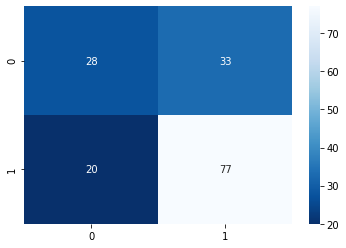

In [148]:
cm = confusion_matrix(y_test_6, predictions_6)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

## 6.2. Проанализируем модель регрессии.

recall > precision

Значит модель совершает ошибки FP чаще FN. Значит эффективнее избегает ошибок второго рода. 

Я считаю, что критичнее ошибка первого рода, так как если модель ошибется и выдаст невкусное молоко за вкусное, заказчик будет недоволен и от его покупателей будет множество жалоб. 

Критичная ошибка - ошибка первого рода. Нужно минимизировать метрику precision.

In [149]:
thresholds = [round(i,2) for i in np.linspace(0.1,1,num =20,endpoint=False)]

df = pd.DataFrame(columns=['threshold', 'precision', 'recall'])
for i in thresholds:
    probabilities = clf.predict_proba(X_test)[:,1]
    predicted_labels = (probabilities>i).astype(int)
    precision = precision_score(y_test_6, predicted_labels)
    recall = recall_score(y_test_6, predicted_labels)
    df = df.append({'threshold': i, 'precision':precision, 'recall':recall}, ignore_index=True)

df

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,precision,recall
0,0.10,0.613924,1.000000
1,0.15,0.613924,1.000000
2,0.19,0.613924,1.000000
3,0.24,0.613924,1.000000
4,0.28,0.613924,1.000000
5,0.32,0.625806,1.000000
6,0.37,0.641892,0.979381
7,0.42,0.671642,0.927835
8,0.46,0.682927,0.865979
9,0.50,0.700000,0.793814


Порог = 0.86

In [163]:
cow_buy

,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age,taste_of_milk,yield_milk
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,вкусное,6200.342346
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,вкусное,6237.822230
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,вкусное,6550.870514
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,вкусное,7953.721799
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,вкусное,6744.243440
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,невкусное,8528.955358
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,вкусное,5817.465105
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,вкусное,6461.193209
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,невкусное,7878.665672
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,вкусное,6235.083633


In [164]:
# Добавим признаки energy_feed_unit, sugar_protein_relationship, raw_protein
cow_buy_2 = pd.concat([
    cow_buy, ferma_main['energy_feed_unit']], ignore_index=False, axis=1)
cow_buy_2['energy_feed_unit'] = cow_buy_2['energy_feed_unit'] * 1.05
cow_buy_3 = pd.concat([
    cow_buy_2, ferma_main['sugar_protein_relationship']], ignore_index=False, axis=1)
cow_buy_3['sugar_protein_relationship'] = cow_buy_3['sugar_protein_relationship'] * 1.05
cow_buy_4 = pd.concat([
    cow_buy_3, ferma_main['raw_protein']], ignore_index=False, axis=1)
cow_buy_4['raw_protein'] = cow_buy_4['raw_protein'] * 1.05
cow_buy_4 = cow_buy_4.dropna()
display(cow_buy_4)

,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age,taste_of_milk,yield_milk,energy_feed_unit,sugar_protein_relationship,raw_protein
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,вкусное,6200.342346,14.910,0.93450,1830.15
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,вкусное,6237.822230,13.440,0.93450,2244.90
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,вкусное,6550.870514,14.700,0.92925,1946.70
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,вкусное,7953.721799,13.020,0.92925,2112.60
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,вкусное,6744.243440,13.440,0.92925,1758.75
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,невкусное,8528.955358,13.335,0.92925,1896.30
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,вкусное,5817.465105,15.435,0.97650,1896.30
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,вкусное,6461.193209,14.070,0.93975,1880.55
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,невкусное,7878.665672,14.385,0.93975,1761.90
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,вкусное,6235.083633,17.325,0.97650,2444.40


In [165]:
cow_buy_5 = cow_buy_4.copy(deep=False)
cow_buy_5['fat_content'] = cow_buy_5['fat_content'].apply(lambda x: 1 if x>= 3.68 else 0)
cow_buy_5['sugar_protein_relationship'] = cow_buy_5['sugar_protein_relationship'].apply(lambda x: 1 if x>= 0.915 else 0)
cow_buy_5['energy_feed_unit_2'] = cow_buy_5['energy_feed_unit'] ** 2
display(cow_buy_5)

,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age,taste_of_milk,yield_milk,energy_feed_unit,sugar_protein_relationship,raw_protein,energy_feed_unit_2
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0,3.076,более_2_лет,вкусное,6200.342346,14.910,1,1830.15,222.308100
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,0,3.081,менее_2_лет,вкусное,6237.822230,13.440,1,2244.90,180.633600
2,РефлешнСоверинг,равнинное,Соверин,Барин,0,3.074,более_2_лет,вкусное,6550.870514,14.700,1,1946.70,216.090000
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,0,3.061,более_2_лет,вкусное,7953.721799,13.020,1,2112.60,169.520400
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,0,3.074,более_2_лет,вкусное,6744.243440,13.440,1,1758.75,180.633600
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,0,3.053,менее_2_лет,невкусное,8528.955358,13.335,1,1896.30,177.822225
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,0,3.079,более_2_лет,вкусное,5817.465105,15.435,1,1896.30,238.239225
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,0,3.079,менее_2_лет,вкусное,6461.193209,14.070,1,1880.55,197.964900
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,1,3.055,более_2_лет,невкусное,7878.665672,14.385,1,1761.90,206.928225
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,1,3.073,более_2_лет,вкусное,6235.083633,17.325,1,2444.40,300.155625


In [154]:
# Кодируем категориальные признаки с помощью OneHotEncoder.
cat_col_names = ['age', 'breed', 'fat_content', 'sugar_protein_relationship']
X_test_ohe = encoder_6.transform(cow_buy_5[cat_col_names]) 
encoder_col_names = encoder_6.get_feature_names()
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [155]:
# Масштабируем количественные признаки с помощью StandardScaler.
num_col_names = ['energy_feed_unit_2', 'raw_protein', 'protein']
X_test_scaled = scaler_6.transform(cow_buy_5[num_col_names])

X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

In [167]:
# Получим прогноз удоя коров
#predictions_6 = clf.predict(X_test)
#predictions_6
y_pred_new_threshold = (clf.predict_proba(X_test)[:,1]>=0.86).astype(int)
y_pred_new_threshold

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Итоговые выводы

In [168]:
cow_buy["taste_of_milk"] = y_pred_new_threshold

In [169]:
cow_buy["taste_of_milk"] = cow_buy["taste_of_milk"].apply(lambda x: "вкусное" if x>0 else "невкусное")

In [170]:
cow_buy["yield_milk"] = predictions_4

In [171]:
cow_buy

,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age,taste_of_milk,yield_milk
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,невкусное,6200.342346
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,невкусное,6237.822230
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,невкусное,6550.870514
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,невкусное,7953.721799
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,невкусное,6744.243440
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,невкусное,8528.955358
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,невкусное,5817.465105
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,невкусное,6461.193209
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,невкусное,7878.665672
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,невкусное,6235.083633


In [172]:
cow_buy[((cow_buy["yield_milk"] > 6000) & (cow_buy["taste_of_milk"]=="вкусное"))]

,breed,pasture_type,bull_breed,name_of_dad,fat_content,protein,age,taste_of_milk,yield_milk


В результате исследования, можно сказать, что Фермер может из стада на продажу купить ни одной коровы. В результате прогноза есть 15 коров с удоем больше 6кг за год, но нет ни одной, у которой будет вкусное молоко.

Для улучшения качества регрессионной модели количественные признаки **fat_content** и **sugar_protein_relationship** я перевела в категориальные бинарные.
Также признак **energy_feed_unit** возвела в квадрат.

При анализе рисков или экономеческих расчетов важны следующие метрики моделей классификации: Precision, Recall, Accuracy